In [1]:
from sklearn.datasets import make_moons

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
import matplotlib.pyplot as plt

In [4]:
dataset, datalabel = make_moons(n_samples=1000, noise = 0.5)

plt.scatter(dataset[:,0][datalabel == 1], dataset[:,1][datalabel == 1], marker = 'x')
plt.scatter(dataset[:,0][datalabel == 0], dataset[:,1][datalabel == 0], marker = 'o')

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, datalabel, test_size = 0.33, random_state = 42)

In [7]:
print(X_train.shape)
print(X_test.shape)

(670, 2)
(330, 2)


In [177]:
from sklearn.ensemble import VotingClassifier

forest = RandomForestClassifier()
svc = SVC(probability=False)
lin = LogisticRegression()

voting = VotingClassifier(estimators=[
    ('forest', forest),
    ('svc', svc),
    ('lin', lin)
], voting='hard')

In [178]:
voting.fit(X_train, y_train)
forest.fit(X_train, y_train)
svc.fit(X_train, y_train)
lin.fit(X_train, y_train)

LogisticRegression()

In [179]:
print(f'forest : {forest.score(X_test, y_test)}')
print(f'svc : {svc.score(X_test, y_test)}')
print(f'lin : {lin.score(X_test, y_test)}')

forest : 0.7909090909090909
svc : 0.8181818181818182
lin : 0.8151515151515152


In [180]:
voting.score(X_test, y_test)

0.8181818181818182

## Question 1 . 
It is possible to combine the different models that train on the exact same training data. The point is that these model should independently learning on different parameters.

## Question 2  
1. Hard voting classifiers predict the final results from majority voting, which may be more fluctuate since it is neglect the confindence level (it treat 0.501 as same as 0.999) . 
2. Soft voting predict the final results from the average of prability of the prediction of each predictors.

## Question 3 . 
* For bagging ensemble, it is possible to training on different server, since this method is independently sampling the input features with replacement.  
* For pasting ensemble, which require that the sampling of input instances must not be used more than once across multiple predictors, it may possible with the load map reduce method which specify one server to distribute the training data to another server.  
* Boostin ensemble requires predictors to predict sequentially, so it is not possible to train on multiple servers.  
* RandomForest with bagging ensemble is the same as bagging ensemble . 
* Stacking ensemble is possible to train on multiple servers by assign one server to distribute the two datasets (first for training first predictor layer and first for create new input features) 


## Question 4 . 
With out of bag evaluation, we doesn't need to split training set into train and validation set. Thus, the model is utilize the whole training set.

## Question 5 . 
Extra-trees key different from Randomforest is that the threshold of the selected feature is randomly chosen (normally, in each split both feature and threshold will be optimally chosen).  
This lead to the fact that extra-trees will have higher bias because it cannot fit the training set so well. But it will make each predictors more independently (Even the same features might have different threshold).  
And from the fact that threshold is randomly selected, it will speed up the training.

## Question 6 . 
Aside from the hyperparameter of the base predictors, hyperparameter of the adaboost is the learning rate. So, we can increase the learning rate to enhance the contribution of the successor predictors and make it more accurate on the training set.

## Question 7  
We should decrease the learning rate to reduce the contribution on the successor predictor to mitigate overfitting problem.

## Question 8  


In [10]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict, train_test_split

import numpy as np

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train = X_train/255
X_test = X_test/255

In [16]:
print(f'X_train shape : {X_train.shape}')
print(f'X_test shape : {X_test.shape}')

print(np.max(X_train))
print(np.max(y_train))

X_train shape : (56000, 784)
X_test shape : (14000, 784)
1.0
9


In [17]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [18]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
ext_clf = ExtraTreesClassifier()
ext_clf.fit(X_train, y_train)

ExtraTreesClassifier()

In [1]:
import pickle
import joblib
import os
import sys

os.mkdir('./gg')
# !mkdir saved_model
# !mkdir ./saved_model/ch7-ensemble

# SAVED_ROOT = './saved_model/ch7-ensemble'

# # with open(os.path.join(SAVED_ROOT, 'logistic-regression'), 'wb') as f:
# #     pickle.dump(log_reg, f)

# # with open(SAVED_ROOT + 'randomforest', 'wb') as f:
# #     pickle.dump(forest_clf, f)

# # with open(SAVED_ROOT + 'extratree', 'wb') as f:
# #     pickle.dump(ext_clf, f)

# joblib.dump(log_reg, os.path.join(SAVED_ROOT, 'logistic-regression'))

In [36]:
log_reg.score(X_test, y_test)

0.9202857142857143

0.9666428571428571


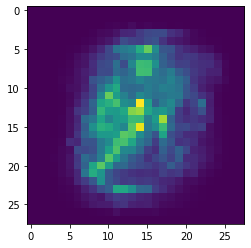

In [56]:
import matplotlib.pyplot as plt
print(forest_clf.score(X_test, y_test))
feature_importances = forest_clf.feature_importances_

plt.imshow(feature_importances.reshape(28,28))

0.9695


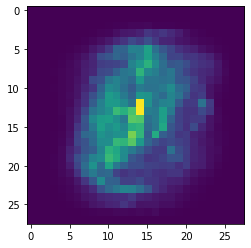

In [58]:
print(ext_clf.score(X_test, y_test))

feature_importances = ext_clf.feature_importances_

plt.imshow(feature_importances.reshape(28,28))

In [92]:
## soft_voting
def soft_voting(estimators, X):
    
    y = np.zeros((X.shape[0], 10))

    for estimator in estimators:
        y = y + estimator.predict_proba(X)

    y = y/len(estimators)
    y = np.argmax(y, axis = 1)
    
    return y.astype('int')

y_test_pred = soft_voting([log_reg, forest_clf, ext_clf], X_test)

def hard_voting(estimators, X):
    
    y = np.zeros((X.shape[0], len(estimators)))

    for ind, estimator in enumerate(estimators):
        y[:, ind] = estimator.predict(X).astype('int')
    
    return y

y_test_pred_hard = hard_voting([log_reg, forest_clf, ext_clf], X_test)

In [89]:
print(y_test_pred_hard.astype('str'))

[['8.0' '8.0' '8.0']
 ['4.0' '4.0' '4.0']
 ['5.0' '8.0' '8.0']
 ...
 ['2.0' '2.0' '2.0']
 ['7.0' '7.0' '7.0']
 ['1.0' '1.0' '1.0']]


In [61]:
from scipy import stats

y_test_predclass_hard = stats.mode(y_test_pred_hard, axis = 1)

In [102]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_test_predclass.astype('str'))

0.9556428571428571

In [80]:
print(np.array(y_test_predclass_hard)[0].shape)
print(accuracy_score(np.array(y_test_predclass_hard)[0].astype('int').astype('str'), y_test))

(14000, 1)
0.9667857142857142


In [78]:
print(np.array(y_test_predclass_hard)[0].astype('int').astype('str'))
print(y_test)

[['8']
 ['4']
 ['8']
 ...
 ['2']
 ['7']
 ['1']]
['8' '4' '8' ... '2' '7' '1']


## Question 9

In [86]:
# further divide the test set into validation set

X_valid, X_test2, y_valid, y_test2 = train_test_split(X_test, y_test, test_size = 0.5)

In [94]:
y_valid_pred_hard = hard_voting([log_reg, forest_clf, ext_clf], X_valid)
print(y_valid_pred_hard.shape)

(7000, 3)


In [95]:
blender = LogisticRegression()
blender.fit(y_valid_pred_hard, y_valid)

LogisticRegression()

In [96]:
blender.score(y_valid_pred_hard, y_valid)

0.9525714285714286

In [97]:
def stacking_ensemble(first_predictors, blender, X):
    new_X = hard_voting(first_predictors, X)
    y = blender.predict(new_X)
    return y

In [98]:
y_test2_pred = stacking_ensemble([log_reg, forest_clf, ext_clf], blender, X_test2)

In [100]:
print(y_test2_pred)
print(y_test2)

['5' '5' '7' ... '8' '0' '2']
['5' '5' '7' ... '9' '0' '2']


In [101]:
accuracy_score(y_test2, y_test2_pred)

0.9488571428571428